In [14]:
import scipy.ndimage.filters
import numpy as np
from skimage import feature
import glob
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.externals import joblib
import tensorflow as tf
# from nets import inception
# from preprocessing import inception_preprocessing


In [15]:
# image to features
def feature_computation(image_arr):
    
#     image to numpy array

#     image = Image.fromarray(image_arr)

    image = image_arr   
    
    
    features = []
    laplacian0 = scipy.ndimage.filters.laplace(image[:,:,0])
    laplacian1 = scipy.ndimage.filters.laplace(image[:,:,1])
    laplacian2 = scipy.ndimage.filters.laplace(image[:,:,2])
    
#     lap_mat0 = np.matrix(laplacian[:,:,0])
#     lap_mat1 = np.matrix(laplacian[:,:,1])
#     lap_mat2 = np.matrix(laplacian[:,:,2])

    lap_mat0 = laplacian0
    lap_mat1 = laplacian1
    lap_mat2 = laplacian2
    
    
    
    features.append(lap_mat0.sum())
    features.append(lap_mat1.sum())
    features.append(lap_mat2.sum())
    
#     image_gray = image.convert('LA')
    image_gray = (image[:,:,0] + image[:,:,1] + image[:,:,2])/3
#     gray_array = np.array(image_gray)[:,:,0]
    gray_array = image_gray
    edges = feature.canny(gray_array,sigma = 3,low_threshold=5, high_threshold=20)
    max_val = np.amax(edges)

    
    for j in range(0,edges.shape[1]):
        for i in range(0,edges.shape[0]):
            if edges[i][j] > .1*max_val:
                edges[i][j] = 0
                if edges[i+1][j] < .1*max_val:
                    break
        for ii in range(0,edges.shape[0]):
            i = edges.shape[0] - ii -1
            if edges[i][j] > .1*max_val:
                edges[i][j] = 0
                if edges[i-1][j] < .1*max_val:
                    break
                    
    features.append(edges.sum())
    
    return features

    

    
    

In [16]:
def random_forest_predictor(image_arr_list):
    
#     image = Image.fromarray(image_arr, 'RGB')


    ind1,ind2,ind3,ind4 = image_arr_list.shape



#     print("print input inside predictor "+str(image_arr_list.shape))
#     print("print input list's length "+str(ind1))
    
    predictions = []

    for i in range(0,ind1):
        
#         print(i)
        image_arr = image_arr_list[i,:,:,:]
    
    
        feature_vec = feature_computation(image_arr)
        model = joblib.load("radom_forest_model.pkl")
        single_prediction = model.predict([feature_vec])
        if single_prediction == True:
            predictions.append([1,0]) # means true/infected
        else:
            predictions.append([0,1]) # means false/uninfected
            
    
    return predictions
    

image size after opened (100, 106)
image prediction: [[0, 1]]
print image array size (106, 100, 3)
print array after resized (100, 106, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


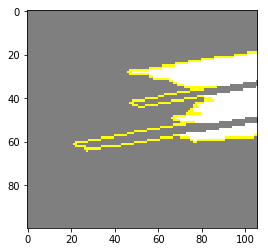

In [31]:

from lime import lime_image
import time
from skimage.segmentation import mark_boundaries
import glob


image_for_explanation=[]
for filename in glob.glob('./explain_images/*.png'):
    im=Image.open(filename)
    image_for_explanation.append(im.copy())

#     image_raw = tf.image.decode_png(im, channels=3)
#     image_for_explanation(image_raw.copy())
    im.close()
    
# for im in image_for_explanation:
# #     plt.imshow(im)
# #     plt.show()
#     print(str(feature_computation(im))+ "prediction: " + str(random_forest_predictor(im)) )


image = image_for_explanation[2]
id1 , id2 = image.size



print("image size after opened "+str(image.size))

im_arr = np.asarray(image)
im_arr_arr = np.asarray([im_arr])


print("image prediction:",str(random_forest_predictor(im_arr_arr)))

print("print image array size "+str(im_arr.shape))

im_resized = np.reshape(im_arr,(id1,id2,3))
print("print array after resized "+str(im_resized.shape))


test_image =  im_resized
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(test_image, random_forest_predictor, batch_size = 10, num_samples=100,top_labels=2)
temp, mask = explanation.get_image_and_mask(label=0, positive_only=True, num_features=10000, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


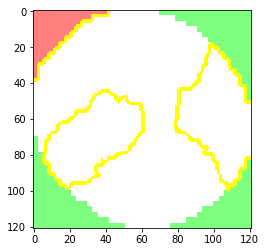

In [29]:
temp, mask = explanation.get_image_and_mask(label=0, positive_only=False, num_features=10000, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


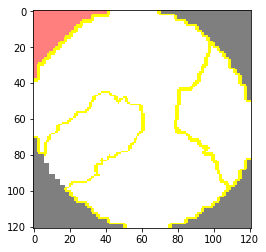

In [30]:
temp, mask = explanation.get_image_and_mask(label=0, positive_only=False, num_features=10000, hide_rest=False, min_weight = 0.08)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))